In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
pd.options.display.max_columns = None
%matplotlib inline

from venn import venn
from scipy.stats import fisher_exact

In [2]:
mutect_df = pd.read_csv("../immortal_simon/mutect/DATA_MUTECT.tsv", sep="\t")
sv_df = pd.read_csv("../immortal_simon/gridss/DATA_GRIDSS.tsv", sep="\t").drop_duplicates()
type_list = {'MUTECT':mutect_df, 'SV':sv_df}

In [3]:
samples = pd.read_csv("../data/samples/SAMPLES_Excel.tsv", sep="\t")
samples['label'] = samples.apply(lambda x: "T" if x['TMM'] == 'TEL' else "M"
                                 if (x['WestATRX'] == "Neg" or x['WestDAXX'] == "Neg") else "AP",
                                 axis=1)

In [4]:
samples = samples[samples['Mortal'].str.contains('JFCF')]

In [5]:
gene_list = ['ATRX', 'DAXX', 'TP53']
sample_list = np.concatenate(
    (samples['Immortal'].unique(), samples['Mortal'].unique()))
type_list = {'Somatic': mutect_df, 'SV': sv_df}
sv_df = sv_df[sv_df['Key'].str.contains('_Somatic')]

In [6]:
mapping = dict(zip(samples['Immortal'].values, samples['label'].values))
combined_df_all = pd.concat([mutect_df, sv_df])

In [7]:
df = combined_df_all[
    (combined_df_all['Impact'].isin(['HIGH', 'MODERATE']))
    & (combined_df_all['Name'] != 'JFCF_6_P_pLKO_5') &
    (combined_df_all['Name'].str.contains('JFCF'))].sort_values(
        by=['Key', 'Name'])

df = df.drop_duplicates(
    subset=df.columns.values[df.columns.values != 'Consequence'])
df = df.drop_duplicates(subset=['Key', 'Name'])

In [8]:
df_TEL = df[df['Name'].isin(samples[samples['TMM']=='TEL']['Immortal'])]
df_ALT = df[df['Name'].isin(samples[samples['TMM']=='ALT']['Immortal'])]
df_Mortal = df[df['Name'].isin(samples['Mortal'])]

# ALT vs TEL mutations

In [9]:
mutations = {
    'TEL': set(df_TEL['Key']),
    'ALT': set(df_ALT['Key'])
}

Text(0.5, 1.0, 'TEL/ALT/Mortal Distinct Mutations')

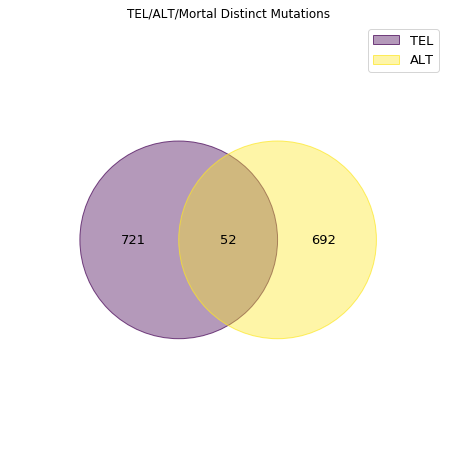

In [10]:
venn(mutations)
plt.title("TEL/ALT/Mortal Distinct Mutations")

In [11]:
res = pd.DataFrame({'Key':df['Key'].unique()})
for key, value in mutations.items():
    res[key] = res['Key'].map(lambda x:True if x in value else False)
key_gene = df.groupby(['Key','Gene','Consequence']).size().reset_index().drop([0], axis=1)

key_gene = key_gene.drop_duplicates("Key", keep='first')

res = pd.merge(res, key_gene, on=['Key'])

res = res.sort_values(by=['Gene','Key'])

In [13]:
res.to_csv("../results/mutations_TEL_ALT_somatic_new_highmoderate.tsv", index=False, sep="\t")

In [14]:
mutations_genes = {
    'TEL': set(df_TEL['Gene']),
    'ALT': set(df_ALT['Gene'])
}

Text(0.5, 1.0, 'TEL/ALT/Mortal Mutated Genes')

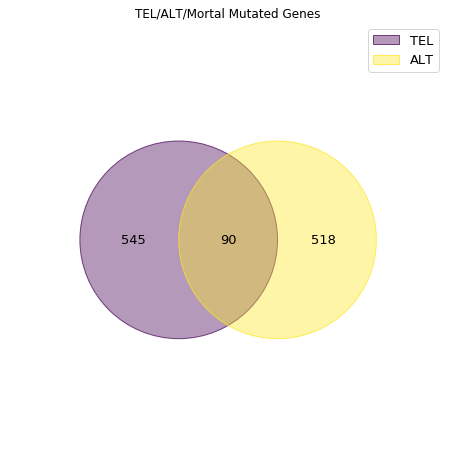

In [15]:
venn(mutations_genes)
plt.title("TEL/ALT/Mortal Mutated Genes")

In [16]:
tel_only = set(df_TEL['Key']) - set(df_ALT['Key']) - set(df_Mortal['Key'])
alt_only = set(df_ALT['Key']) - set(df_TEL['Key']) - set(df_Mortal['Key'])
mortal_only = set(df_Mortal['Key']) - set(df_ALT['Key']) - set(df_TEL['Key'])

In [17]:
alt_mutations = df[df['Key'].isin(alt_only)][['Gene', 'Name', 'Impact']].drop_duplicates().groupby(
    ['Gene']).size().sort_values(ascending=False).reset_index()

In [18]:
tel_mutations = df[df['Key'].isin(tel_only)][['Gene', 'Name', 'Impact']].drop_duplicates().groupby(
    ['Gene']).size().sort_values(ascending=False).reset_index()

In [19]:
alt_mutations.columns = ['Gene', 'count']
alt_mutations.to_csv("../results/alt_only_mutations_JFCF_only_somatic_new_highmoderate.tsv", index=False, sep='\t')

In [20]:
tel_mutations.columns = ['Gene', 'count']

tel_mutations.to_csv("../results/tel_only_mutations_JFCF_only_somatic_new_highmoderate.tsv", index=False, sep='\t')

Check TERT. It seems both ALT and TEL have TERT mutations.

In [22]:
samples[samples['Immortal'].isin(df[df['Gene']=='TERT']['Name'].unique())]

,Mortal,Immortal,TMM,WestATRX,WestDAXX,SWATH,label


In [23]:
df['Pos1'] = df['Pos1'].astype(str)

In [24]:
df[df['Gene']=='CBWD1'].sort_values(by=['Name'])

,Key,Name,Source,dbSNP,Type,Chr1,Pos1,Chr2,Pos2,Qual1,Qual2,AF1,AF2,Read1,Read2,Gene,Consequence,Impact,Ref1,Alt1,Ref2,Alt2


In [25]:
df.to_csv("../results/all_JFCF_mutations_details_no_plko_somatic_new_highmoderate.tsv", index=False, sep="\t")

In [26]:
df.head()

,Key,Name,Source,dbSNP,Type,Chr1,Pos1,Chr2,Pos2,Qual1,Qual2,AF1,AF2,Read1,Read2,Gene,Consequence,Impact,Ref1,Alt1,Ref2,Alt2
42121,IND_MuTect2_HIGH_AFF1_chr4_88048827_AAA_TGT,JFCF_6_T_1_D,MuTect2,False,IND,chr4,88048827,NaN,NaN,7.83:1.44,NaN,0.714,0.035,"[5, 14]","[26, 0]",AFF1,stop_gained,HIGH,AAA,TGT,NaN,NaN
93586,IND_MuTect2_HIGH_AKAP12_chr6_151673338_CTG_C,JFCF_6_T_1_P_TEL,MuTect2,False,IND,chr6,151673338,NaN,NaN,7.22:1.41,NaN,0.541,0.038,"[16, 19]","[24, 0]",AKAP12,frameshift_variant,HIGH,CTG,C,NaN,NaN
73379,IND_MuTect2_HIGH_ARHGAP39_chr8_145770781_CT_C,JFCF_6_T_1_H,MuTect2,False,IND,chr8,145770781,NaN,NaN,7.53:1.41,NaN,0.367,0.037,"[11, 6]","[25, 0]",ARHGAP39,frameshift_variant,HIGH,CT,C,NaN,NaN
73382,IND_MuTect2_HIGH_ARHGAP39_chr8_145770786_GGCAC...,JFCF_6_T_1_H,MuTect2,False,IND,chr8,145770786,NaN,NaN,8.13:1.45,NaN,0.314,0.034,"[12, 5]","[27, 0]",ARHGAP39,frameshift_variant,HIGH,GGCACAGC,G,NaN,NaN
52975,IND_MuTect2_HIGH_CMTR1_chr6_37442303_T_TGATACG...,JFCF_6_T_1_F,MuTect2,False,IND,chr6,37442303,NaN,NaN,12.64:1.63,NaN,0.154,0.023,"[21, 3]","[42, 0]",CMTR1,stop_gained&frameshift_variant,HIGH,T,TGATACGGCGACCA,NaN,NaN


# All ALT & All TEL

In [27]:
df_ALT_genes = set(df_ALT['Gene']) - set(df_Mortal['Gene'])
df_TEL_genes = set(df_TEL['Gene']) - set(df_Mortal['Gene'])

In [28]:
df_ALT_no_mortal = df_ALT[df_ALT['Gene'].isin(df_ALT_genes)]
df_TEL_no_mortal = df_TEL[df_TEL['Gene'].isin(df_TEL_genes)]

In [29]:
df_ALT_no_mortal[['Name', 'Gene']].drop_duplicates().groupby(
    ['Gene']).size().sort_values(ascending=False).head(20)

Gene
ATRX         9
MYO18A       7
CTNS         6
NTRK2        6
IGF1R        5
CDH1         5
EVI5         4
APOB         4
SERPINA12    4
SBSN         4
ZNF827       4
PSMB7        3
IGLL5        3
SUGCT        3
PARK2        3
NBPF12       3
MUC4         3
U1.8         3
FXN          2
DGKK         2
dtype: int64

In [30]:
df_TEL_no_mortal[['Name', 'Gene']].drop_duplicates().groupby(
    ['Gene']).size().sort_values(ascending=False).head(20)

Gene
ZNF827       6
SUGCT        5
CTNS         5
SERPINA12    5
IGF1R        5
MYO18A       5
NTRK2        4
APOB         4
EVI5         4
SBSN         4
CDH1         4
MUC4         4
CEP170       3
SLC25A5      3
CSMD3        3
AUTS2        3
MYO9B        3
NAALADL2     3
TP53TG3D     3
NBPF10       3
dtype: int64

In [32]:
df_TEL[df_TEL['Gene']=='ZNF827']

,Key,Name,Source,dbSNP,Type,Chr1,Pos1,Chr2,Pos2,Qual1,Qual2,AF1,AF2,Read1,Read2,Gene,Consequence,Impact,Ref1,Alt1,Ref2,Alt2
614470,SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146807211_1...,JFCF_6_T_1J_11C,GRIDSS,False,Deletion,chr4,146807211-146807212,chr4,146823317-146823318,NotSplit:199.65;Split:28.3,NotSplit:199.65;Split:28.3,NaN,NaN,NotSplit:11;Split:1,NotSplit:11;Split:1,ZNF827,gene_fusion&frameshift_variant,HIGH,A,AGGCTTTCCACTTTCCTCTTCTGAGG[CHR4:146823318[,C,]CHR4:146807212]GGCTTTCCACTTTCCTCTTCTGAGGC
217314,SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146807211_1...,JFCF_6_T_1_C,GRIDSS,False,Deletion,chr4,146807211-146807212,chr4,146823317-146823318,NotSplit:479.78;Split:319.62,NotSplit:479.78;Split:319.62,NaN,NaN,NotSplit:26;Split:11,NotSplit:26;Split:11,ZNF827,gene_fusion&frameshift_variant,HIGH,A,AGGCTTTCCACTTTCCTCTTCTGAGG[CHR4:146823318[,C,]CHR4:146807212]GGCTTTCCACTTTCCTCTTCTGAGGC
377622,SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146807211_1...,JFCF_6_T_1_F,GRIDSS,False,Deletion,chr4,146807211-146807212,chr4,146823317-146823318,NotSplit:403.27;Split:196.97,NotSplit:403.27;Split:196.97,NaN,NaN,NotSplit:22;Split:7,NotSplit:22;Split:7,ZNF827,gene_fusion&frameshift_variant,HIGH,A,AGGCTTTCCACTTTCCTCTTCTGAGG[CHR4:146823318[,C,]CHR4:146807212]GGCTTTCCACTTTCCTCTTCTGAGGC
454346,SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146807211_1...,JFCF_6_T_1_G,GRIDSS,False,Deletion,chr4,146807211-146807212,chr4,146823317-146823318,NotSplit:313.83;Split:335.65,NotSplit:313.83;Split:335.65,NaN,NaN,NotSplit:17;Split:11,NotSplit:17;Split:11,ZNF827,gene_fusion&frameshift_variant,HIGH,A,AGGCTTTCCACTTTCCTCTTCTGAGG[CHR4:146823318[,C,]CHR4:146807212]GGCTTTCCACTTTCCTCTTCTGAGGC
532205,SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146807211_1...,JFCF_6_T_1_H,GRIDSS,False,Deletion,chr4,146807211-146807212,chr4,146823317-146823318,NotSplit:163.83;Split:171.71,NotSplit:163.83;Split:171.71,NaN,NaN,NotSplit:9;Split:6,NotSplit:9;Split:6,ZNF827,gene_fusion&frameshift_variant,HIGH,A,AGGCTTTCCACTTTCCTCTTCTGAGG[CHR4:146823318[,C,]CHR4:146807212]GGCTTTCCACTTTCCTCTTCTGAGGC
1067852,SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146807211_1...,JFCF_6_T_1_P_TEL,GRIDSS,False,Deletion,chr4,146807211-146807212,chr4,146823317-146823318,NotSplit:165.15;Split:230.39,NotSplit:165.15;Split:230.39,NaN,NaN,NotSplit:9;Split:8,NotSplit:9;Split:8,ZNF827,gene_fusion&frameshift_variant,HIGH,A,AGGCTTTCCACTTTCCTCTTCTGAGG[CHR4:146823318[,C,]CHR4:146807212]GGCTTTCCACTTTCCTCTTCTGAGGC
614472,SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146824366_1...,JFCF_6_T_1J_11C,GRIDSS,False,Deletion,chr4,146824366-146824367,chr4,146859516-146859517,NotSplit:36.3;Split:290.68,NotSplit:36.3;Split:290.68,NaN,NaN,NotSplit:2;Split:11,NotSplit:2;Split:11,ZNF827,gene_fusion,HIGH,T,T[CHR4:146859517[,G,]CHR4:146824367]G
217316,SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146824366_1...,JFCF_6_T_1_C,GRIDSS,False,Deletion,chr4,146824366-146824367,chr4,146859516-146859517,NotSplit:92.26;Split:332.77,NotSplit:92.26;Split:332.77,NaN,NaN,NotSplit:5;Split:12,NotSplit:5;Split:12,ZNF827,gene_fusion,HIGH,T,T[CHR4:146859517[,G,]CHR4:146824367]G
377624,SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146824366_1...,JFCF_6_T_1_F,GRIDSS,False,Deletion,chr4,146824366-146824367,chr4,146859516-146859517,NotSplit:54.99;Split:650.74,NotSplit:54.99;Split:650.74,NaN,NaN,NotSplit:3;Split:24,NotSplit:3;Split:24,ZNF827,gene_fusion,HIGH,T,T[CHR4:146859517[,G,]CHR4:146824367]G
454348,SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146824366_1...,JFCF_6_T_1_G,GRIDSS,False,Deletion,chr4,146824366-146824367,chr4,146859516-146859517,NotSplit:55.38;Split:202.04,NotSplit:55.38;Split:202.04,NaN,NaN,NotSplit:3;Split:7,NotSplit:3;Split:7,ZNF827,gene_fusion,HIGH,T,T[CHR4:146859517[,G,]CHR4:146824367]G


In [34]:
df_ALT[df_ALT['Gene']=='TERT']

,Key,Name,Source,dbSNP,Type,Chr1,Pos1,Chr2,Pos2,Qual1,Qual2,AF1,AF2,Read1,Read2,Gene,Consequence,Impact,Ref1,Alt1,Ref2,Alt2
102753,SNP_MuTect2_MODIFIER_TERT_chr5_1284675_T_C,JFCF_6_T_1_P_ALT,MuTect2,False,SNP,chr5,1284675,NaN,NaN,2.27:0.761,NaN,0.62,0.091,"[3, 5]","[8, 0]",TERT,intron_variant,MODIFIER,T,C,NaN,NaN


## Matrix

In [168]:
df_ALT_mat = df_ALT.groupby(['Name', 'Gene']).size()
df_ALT_mat = df_ALT_mat.reset_index(name='count')
df_ALT_mat = df_ALT_mat.pivot(columns='Name', index='Gene', values='count').fillna(0)

In [169]:
df_TEL_mat = df_TEL.groupby(['Name', 'Gene']).size()
df_TEL_mat = df_TEL_mat.reset_index(name='count')

df_TEL_mat = df_TEL_mat.pivot(columns='Name', index='Gene', values='count').fillna(0)


In [170]:
df_mat = pd.merge(df_ALT_mat,df_TEL_mat, how='outer', on='Gene').fillna(0).astype(int)

In [172]:
df_mat.to_csv("../results/telnet_mat_highmoderate.tsv", sep='\t')

# ALT and TEL specific

In [43]:
df_ALT_mutations = set(df_ALT['Key'].unique())
df_TEL_mutations = set(df_TEL['Key'].unique())

In [44]:
df_ALT_specific_mutations = df_ALT_mutations - df_TEL_mutations
df_TEL_specific_mutations = df_TEL_mutations - df_ALT_mutations

In [45]:
df_ALT_specific = df_ALT[df_ALT['Key'].isin(df_ALT_specific_mutations)]
df_TEL_specific = df_TEL[df_TEL['Key'].isin(df_TEL_specific_mutations)]

In [46]:
df_ALT_specific[['Name', 'Gene']].drop_duplicates().groupby(
    ['Gene']).size().sort_values(ascending=False).head(20)

Gene
ATRX         9
PARK2        3
NBPF12       3
IGLL5        3
MMP11        2
CTNNA2       2
FXN          2
CHD6         2
UMAD1        2
SAMD12       2
C2CD3        2
IGFN1        2
CREB5        2
TMTC1        2
LINC01220    2
IDH3A        2
ARHGEF3      2
TNS3         2
CNTN5        2
HMGA2        2
dtype: int64

In [145]:
df_TEL_specific[['Name', 'Gene']].drop_duplicates().groupby(
    ['Gene']).size().sort_values(ascending=False).head(6)

Gene
MYO9B       3
MUC4        3
NAALADL2    3
AUTS2       3
TP53TG3D    3
CSMD3       3
dtype: int64

# ALT vs TEL Fisher Test

In [141]:
df_count_merge = pd.merge(
    df_ALT_no_mortal[['Name', 'Gene']].drop_duplicates().groupby(
        ['Gene']).size().reset_index(name='count_ALT'),
    df_TEL_no_mortal[['Name', 'Gene']].drop_duplicates().groupby(
        ['Gene']).size().reset_index(name='count_TEL'), how='outer').fillna(0)

In [142]:
df_count_merge.head()

,Gene,count_ALT,count_TEL
0,A2M,1.0,0.0
1,AARD,1.0,0.0
2,ABI1,1.0,0.0
3,AC096644.1,1.0,0.0
4,AC131097.4,1.0,0.0


In [173]:
df_count_merge['p_value'] = df_count_merge.apply(lambda row: fisher_exact(
    np.array([[row['count_ALT'], row['count_TEL']],
              [9 - row['count_ALT'], 8 - row['count_TEL']]]))[1], axis=1)
df_count_merge['p_value_less'] = df_count_merge.apply(lambda row: fisher_exact(
    np.array([[row['count_ALT'], row['count_TEL']],
              [9 - row['count_ALT'], 8 - row['count_TEL']]]), alternative='less')[1], axis=1)
df_count_merge['p_value_greater'] = df_count_merge.apply(lambda row: fisher_exact(
    np.array([[row['count_ALT'], row['count_TEL']],
              [9 - row['count_ALT'], 8 - row['count_TEL']]]), alternative='greater')[1], axis=1)

In [144]:
df_count_merge.sort_values(by=['p_value'])

,Gene,count_ALT,count_TEL,p_value
49,ATRX,9.0,0.0,0.000041
1116,TP53TG3D,0.0,3.0,0.082353
729,CSMD3,0.0,3.0,0.082353
646,AUTS2,0.0,3.0,0.082353
933,NAALADL2,0.0,3.0,0.082353
931,MYO9B,0.0,3.0,0.082353
676,C9orf41-AS1&RORB,0.0,2.0,0.205882
839,HSF1.1,0.0,2.0,0.205882
829,GSDMA&PSMD3,0.0,2.0,0.205882
828,GSDMA&MED24,0.0,2.0,0.205882


In [175]:
df_count_merge.to_csv("../results/MUTECT_Fisher_HighModerate.tsv", index=False, sep='\t')

# 1J comparison

In [147]:
df_1J_ALT = df[df['Name'].isin(['JFCF_6_T_1J_11E','JFCF_6_T_1J_1_3C'])]
df_1J_TEL = df[df['Name'].isin(['JFCF_6_T_1J_11C','JFCF_6_T_1J_6B'])]


In [148]:
df_1J_ALT_mutations = set(df_1J_ALT['Key'].unique())
df_1J_TEL_mutations = set(df_1J_TEL['Key'].unique())

df_1J_ALT_specific_mutations = df_1J_ALT_mutations - df_1J_TEL_mutations
df_1J_TEL_specific_mutations = df_1J_TEL_mutations - df_1J_ALT_mutations

df_1J_ALT_specific = df_1J_ALT[df_1J_ALT['Key'].isin(df_1J_ALT_specific_mutations)]
df_1J_TEL_specific = df_1J_TEL[df_1J_TEL['Key'].isin(df_1J_TEL_specific_mutations)]

In [149]:
df_1J_ALT_specific[['Name', 'Gene']].drop_duplicates().groupby(
    ['Gene']).size().sort_values(ascending=False).head(20)

Gene
JAZF1                2
ATRX                 2
HMGA2                2
FXN                  2
LINC01220            2
LOC400684            2
MMP11                2
DPY19L3&LOC400684    2
DGKK                 2
PARK2                2
CNTN5                2
CMIP&WFDC1           2
SAMD12               2
CTNNA2               2
IDH3A                2
ACACA&PARD6G         2
ADAMTSL3&PARD6G      2
ACACA&PARD6G-AS1     2
WFDC1                2
EXOC6                1
dtype: int64

In [150]:
df_1J_TEL_specific[['Name', 'Gene']].drop_duplicates().groupby(
    ['Gene']).size().sort_values(ascending=False).head(20)

Gene
CARNMT1&RORB           2
C9orf41-AS1            2
ADD1                   2
NBPF10                 2
GSDMA&MED24            2
RORB                   2
GSDMA&PSMD3            2
FLG2                   2
CARNMT1                2
C9orf41-AS1&RORB       2
C9orf41-AS1&CARNMT1    2
KISS1                  1
KIF16B                 1
INSRR                  1
IL18RAP                1
INPP5B                 1
ING3                   1
KRTAP10-7              1
IGLL5                  1
IGFN1                  1
dtype: int64

# P_ALT vs P_TEL

In [151]:
df_P_ALT = df[df['Name'].isin(['JFCF_6_T_1_P_ALT'])]
df_P_TEL = df[df['Name'].isin(['JFCF_6_T_1_P_TEL'])]

In [152]:
df_P_ALT_mutations = set(df_P_ALT['Key'].unique())
df_P_TEL_mutations = set(df_P_TEL['Key'].unique())

df_P_ALT_specific_mutations = df_P_ALT_mutations - df_P_TEL_mutations
df_P_TEL_specific_mutations = df_P_TEL_mutations - df_P_ALT_mutations

df_P_ALT_specific = df_P_ALT[df_P_ALT['Key'].isin(df_P_ALT_specific_mutations)]
df_P_TEL_specific = df_P_TEL[df_P_TEL['Key'].isin(df_P_TEL_specific_mutations)]

In [153]:
df_P_ALT_specific[['Name', 'Gene']].drop_duplicates()

,Name,Gene
104289,JFCF_6_T_1_P_ALT,LRGUK
109606,JFCF_6_T_1_P_ALT,ATRX
107382,JFCF_6_T_1_P_ALT,SPG11
99759,JFCF_6_T_1_P_ALT,U1.8
105405,JFCF_6_T_1_P_ALT,ARHGAP12
105876,JFCF_6_T_1_P_ALT,C11orf48
100381,JFCF_6_T_1_P_ALT,C1orf116
109299,JFCF_6_T_1_P_ALT,FAM230A
103375,JFCF_6_T_1_P_ALT,HK3
109234,JFCF_6_T_1_P_ALT,KRTAP10-6


In [154]:
df_P_TEL_specific[['Name', 'Gene']].drop_duplicates()

,Name,Gene
93586,JFCF_6_T_1_P_TEL,AKAP12
94343,JFCF_6_T_1_P_TEL,FGFR1
95631,JFCF_6_T_1_P_TEL,MDK
98475,JFCF_6_T_1_P_TEL,MYO9B
98182,JFCF_6_T_1_P_TEL,RP11-683L23.1
90379,JFCF_6_T_1_P_TEL,CEP170
89612,JFCF_6_T_1_P_TEL,CPSF3L
92362,JFCF_6_T_1_P_TEL,GYPA
91751,JFCF_6_T_1_P_TEL,SLC9A9
97027,JFCF_6_T_1_P_TEL,AHNAK2


# intersection

In [155]:
print(set(df_P_ALT_specific['Gene']).intersection(set(df_1J_ALT_specific['Gene'])))

{'ATRX', 'PIP5K1C'}


In [64]:
set(df_P_TEL_specific['Gene']).intersection(set(df_1J_TEL_specific['Gene']))

{'AUTS2', 'CELA3A', 'MUC4', 'MYO9B', 'NAALADL2', 'TAS2R43'}

# gene list

In [77]:
genes = pd.read_excel('../data/TelomereRelatedGeneList_2020020.xlsx', sheet_name='Overall')

In [83]:
df_gene_list = df[df['Gene'].isin(genes['Gene'])]
df_TEL_gene_list = df_gene_list[df_gene_list['Name'].isin(samples[samples['TMM']=='TEL']['Immortal'])]
df_ALT_gene_list = df_gene_list[df_gene_list['Name'].isin(samples[samples['TMM']=='ALT']['Immortal'])]

## non-specific

In [87]:
df_ALT_gene_list[['Name', 'Gene']].drop_duplicates().groupby(
    ['Gene']).size().sort_values(ascending=False).head(25)

Gene
ATRX        9
ZNF827      4
IDH3A       2
TCOF1       1
TAGLN2      1
CBX3        1
CTC1        1
DCLRE1A     1
E2F3        1
HELZ        1
HIF1A       1
NEK7        1
YWHAE       1
PRMT5       1
SCYL1       1
SIRT1       1
SND1        1
STAT3       1
SUV420H2    1
PAXIP1      1
dtype: int64

In [85]:
df_TEL_gene_list[['Name', 'Gene']].drop_duplicates().groupby(
    ['Gene']).size().sort_values(ascending=False).head(20)

Gene
ZNF827     6
WEE1       1
TEP1       1
TDRD6      1
SND1       1
SMARCA5    1
RPRD1B     1
RB1        1
OLA1       1
MKI67      1
MCPH1      1
MAD1L1     1
GNL3L      1
EIF5A2     1
CSE1L      1
dtype: int64

In [102]:
df_ALT_gene_list_mat = df_ALT_gene_list.groupby(['Name', 'Gene']).size()
df_ALT_gene_list_mat = df_ALT_gene_list_mat.reset_index(name='count')
df_ALT_gene_list_mat = df_ALT_gene_list_mat.pivot(columns='Name', index='Gene', values='count').fillna(0)

In [103]:
df_TEL_gene_list_mat = df_TEL_gene_list.groupby(['Name', 'Gene']).size()
df_TEL_gene_list_mat = df_TEL_gene_list_mat.reset_index(name='count')

df_TEL_gene_list_mat = df_TEL_gene_list_mat.pivot(columns='Name', index='Gene', values='count').fillna(0)


In [108]:
df_gene_list_mat = pd.merge(df_ALT_gene_list_mat,df_TEL_gene_list_mat, how='outer', on='Gene').fillna(0).astype(int)

In [111]:
df_gene_list_mat.to_csv("../results/gene_list_mat_highmoderate.tsv", sep='\t')

## specific

In [89]:
df_ALT_mutations_gene_list = set(df_ALT_gene_list['Key'].unique())
df_TEL_mutations_gene_list = set(df_TEL_gene_list['Key'].unique())

In [90]:
df_ALT_specific_mutations_gene_list = df_ALT_mutations_gene_list - df_TEL_mutations_gene_list
df_TEL_specific_mutations_gene_list = df_TEL_mutations_gene_list - df_ALT_mutations_gene_list

In [91]:
df_ALT_specific_gene_list = df_ALT_gene_list[df_ALT_gene_list['Key'].isin(df_ALT_specific_mutations_gene_list)]
df_TEL_specific_gene_list = df_TEL_gene_list[df_TEL_gene_list['Key'].isin(df_TEL_specific_mutations_gene_list)]

In [100]:
df_ALT_specific_gene_list[['Name', 'Gene']].drop_duplicates().groupby(
    ['Gene']).size().sort_values(ascending=False).head(20)

Gene
ATRX        9
IDH3A       2
YWHAE       1
CBX3        1
CTC1        1
DCLRE1A     1
E2F3        1
HELZ        1
HIF1A       1
NEK7        1
ZNF827      1
PRMT5       1
SCYL1       1
SIRT1       1
SND1        1
STAT3       1
SUV420H2    1
TAGLN2      1
TCOF1       1
PAXIP1      1
dtype: int64

In [101]:
df_TEL_specific_gene_list[['Name', 'Gene']].drop_duplicates().groupby(
    ['Gene']).size().sort_values(ascending=False).head(20)

Gene
WEE1       1
TEP1       1
TDRD6      1
SND1       1
SMARCA5    1
RPRD1B     1
RB1        1
OLA1       1
MKI67      1
MCPH1      1
MAD1L1     1
GNL3L      1
EIF5A2     1
CSE1L      1
dtype: int64

# gene list TelNet

In [156]:
genes = pd.read_csv('../data/TelNet_2093GeneList.csv')

In [157]:
df_gene_list = df[df['Gene'].isin(genes['Gene symbol'])]
df_TEL_gene_list = df_gene_list[df_gene_list['Name'].isin(samples[samples['TMM']=='TEL']['Immortal'])]
df_ALT_gene_list = df_gene_list[df_gene_list['Name'].isin(samples[samples['TMM']=='ALT']['Immortal'])]

## non-specific

In [158]:
df_ALT_gene_list[['Name', 'Gene']].drop_duplicates().groupby(
    ['Gene']).size().sort_values(ascending=False).head(25)

Gene
ATRX        9
ZNF827      4
SLC25A5     2
CREB5       2
DMD         2
FXN         2
HMGA2       2
IDH3A       2
JAZF1       2
SYNE1       1
HIST1H3H    1
HELZ        1
HDAC9       1
TNIK        1
FOXP1       1
EPB41L1     1
E2F3        1
USP18       1
DLG2        1
DHX35       1
DCLRE1A     1
CTC1        1
UTRN        1
CCM2        1
CBX3        1
dtype: int64

In [159]:
df_TEL_gene_list[['Name', 'Gene']].drop_duplicates().groupby(
    ['Gene']).size().sort_values(ascending=False).head(20)

Gene
ZNF827     6
SLC25A5    3
MECOM      2
CMTR1      1
EPHA4      1
MCPH1      1
MAD1L1     1
MACROD2    1
LPIN3      1
KMT2A      1
HNF4A      1
GREM1      1
GNL3L      1
GDAP1L1    1
ELOVL7     1
CPPED1     1
MECP2      1
CACNA1B    1
EIF5A2     1
EHMT1      1
dtype: int64

In [160]:
df_ALT_gene_list_mat = df_ALT_gene_list.groupby(['Name', 'Gene']).size()
df_ALT_gene_list_mat = df_ALT_gene_list_mat.reset_index(name='count')
df_ALT_gene_list_mat = df_ALT_gene_list_mat.pivot(columns='Name', index='Gene', values='count').fillna(0)

In [161]:
df_TEL_gene_list_mat = df_TEL_gene_list.groupby(['Name', 'Gene']).size()
df_TEL_gene_list_mat = df_TEL_gene_list_mat.reset_index(name='count')

df_TEL_gene_list_mat = df_TEL_gene_list_mat.pivot(columns='Name', index='Gene', values='count').fillna(0)


In [162]:
df_gene_list_mat = pd.merge(df_ALT_gene_list_mat,df_TEL_gene_list_mat, how='outer', on='Gene').fillna(0).astype(int)

In [166]:
df_gene_list_mat.to_csv("../results/gene_list_telnet_mat_highmoderate.tsv", sep='\t')

## specific

In [126]:
df_ALT_mutations_gene_list = set(df_ALT_gene_list['Key'].unique())
df_TEL_mutations_gene_list = set(df_TEL_gene_list['Key'].unique())

In [127]:
df_ALT_specific_mutations_gene_list = df_ALT_mutations_gene_list - df_TEL_mutations_gene_list
df_TEL_specific_mutations_gene_list = df_TEL_mutations_gene_list - df_ALT_mutations_gene_list

In [128]:
df_ALT_specific_gene_list = df_ALT_gene_list[df_ALT_gene_list['Key'].isin(df_ALT_specific_mutations_gene_list)]
df_TEL_specific_gene_list = df_TEL_gene_list[df_TEL_gene_list['Key'].isin(df_TEL_specific_mutations_gene_list)]

In [129]:
df_ALT_specific_gene_list[['Name', 'Gene']].drop_duplicates().groupby(
    ['Gene']).size().sort_values(ascending=False).head(20)

Gene
ATRX        9
JAZF1       2
DMD         2
IDH3A       2
HMGA2       2
CREB5       2
FXN         2
HIST1H4K    1
HIST1H3H    1
HIF1A       1
HELZ        1
HDAC9       1
FOXP1       1
EPB41L1     1
E2F3        1
DLG2        1
ZC3H18      1
DHX35       1
DCLRE1A     1
CTC1        1
dtype: int64

In [130]:
df_TEL_specific_gene_list[['Name', 'Gene']].drop_duplicates().groupby(
    ['Gene']).size().sort_values(ascending=False).head(20)

Gene
MECOM      2
WEE1       1
MCPH1      1
MAD1L1     1
MACROD2    1
LPIN3      1
KMT2A      1
HNF4A      1
GREM1      1
GNL3L      1
GDAP1L1    1
EPHA4      1
XRN1       1
EIF5B      1
EIF5A2     1
EHMT1      1
DST        1
DLG2       1
CSE1L      1
CRYM       1
dtype: int64